In [90]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import sklearn.preprocessing
import pandas_datareader.data as web
from pandas import Series, DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import plotly.graph_objects as go

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")


from sklearn.linear_model import SGDClassifier
from sklearn.metrics import explained_variance_score, confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve

start = dt.datetime(2016, 1, 1)
#end = dt.datetime(2019, 1, 11)
end = dt.datetime.today()
# Only thing you should set
ticker = 'CARO'

df = web.DataReader(ticker, 'yahoo', start, end)  # Pick ticker symbol
#df.tail(5)  # Show the last 5
#df.describe() # Stats
#df.info()

(33, 40)

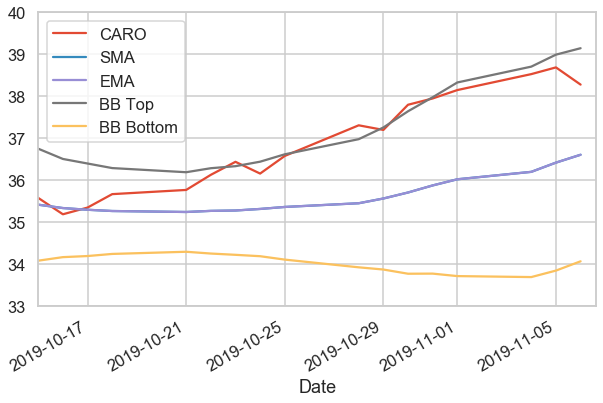

In [91]:
# Simple Moving Average

close_px = df['Adj Close']

window = 20  # set window here

#Simple Moving Average
sma = close_px.rolling(window=window).mean()

#Moving Standard Deviation
msd = close_px.rolling(window=window).std()

#Bollinger Bands
topBand = sma + (2 * msd)
bottomBand = sma - (2 * msd)

#Exponential Moving Average
ema = close_px.ewm(span=window, adjust=False).mean()

close_px.plot(label=ticker)
sma.plot(label='SMA')
sma.plot(label='EMA')
topBand.plot(label='BB Top')
bottomBand.plot(label='BB Bottom')
plt.legend(loc='best')
plt.xlim([dt.date(2019, 10, 15), end])
plt.ylim(33, 40)  # Use for zooming in

In [92]:
x = df.index.to_pydatetime() #Fix for plotly not liking pandas datetime
fig = go.Figure(data=[go.Candlestick(x=x,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])],
                layout_title_text="{} Stock Chart".format(ticker))
fig.show()

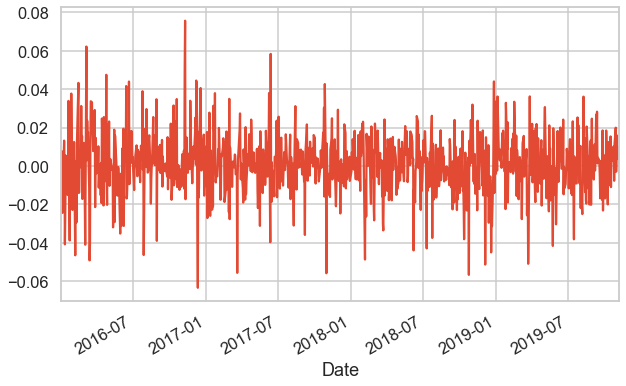

In [93]:
# Risk and Return Deviation
# Risk adverse --> lower drop is better
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

Text(0, 0.5, 'Returns DIS')

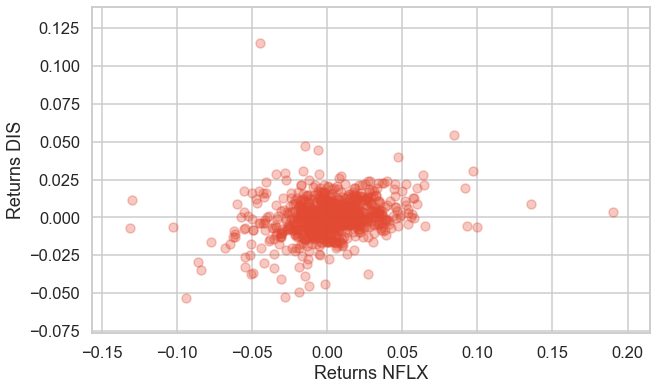

In [94]:
# Lets look at competitors to Ticker selected
# Correlation analysis - Check for positive - whole industry benefits - Negative - Neutral
dfcomp = web.DataReader(['DIS', 'AAPL', 'AMZN', 'NFLX'],'yahoo',start=start,end=end)['Adj Close']
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
plt.scatter(retscomp.NFLX, retscomp.DIS, alpha=.3)
plt.xlabel('Returns NFLX')
plt.ylabel('Returns DIS')

# Apply Continuous Data Algorithms



In [95]:
# Lets do some price predicting using ML
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0   # High Low % change
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0  # Open Close % change
data = dfreg.copy(deep=True)

In [96]:
# Preprocessing so the model works
# Drop missing value
data.fillna(value=0, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(data)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
data['label'] = data[forecast_col].shift(-forecast_out)
X = np.array(data.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = sklearn.preprocessing.scale(X)
# Finally We want to find Data Series of late X (test) and early X (train) for model generation and evaluation
xLately = X[-forecast_out:]
xTrain = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(data['label'])
yTrain = y[:-forecast_out]
data.tail()

,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2019-10-31,37.950001,69300.0,1.660082,0.984563,NaN
2019-11-01,38.150002,75300.0,1.965924,0.394741,NaN
2019-11-04,38.529999,37800.0,1.167923,0.077919,NaN
2019-11-05,38.689999,61300.0,1.380193,-0.232079,NaN
2019-11-06,38.279999,28527.0,2.063743,-0.957316,NaN


In [97]:
# Learning Models
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(xTrain, yTrain)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(xTrain, yTrain)
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(xTrain, yTrain)
# Random Forest Regressor
rfReg = RandomForestRegressor(n_estimators=10)
rfReg.fit(xTrain, yTrain)
# Gradient Boosting Regressor
gboostReg = GradientBoostingRegressor(n_estimators=10)
gboostReg.fit(xTrain, yTrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
params = {"algorithm": ['ball_tree', 'kd_tree', 'brute'],
          "leaf_size": [10, 20, 30, 40],
          "metric": ['minkowski', 'manhattan'],
          "weights": ['uniform', 'distance'],
          "n_neighbors": [5, 7, 10, 12, 15, 20],}

grid_searchKN = GridSearchCV(KNeighborsRegressor(), params, cv=5, n_jobs=-1)

In [99]:
grid_searchKN.fit(xTrain, yTrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40],
                         'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [5, 7, 10, 12, 15, 20],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [100]:
grid_searchKN.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 10,
 'metric': 'minkowski',
 'n_neighbors': 5,
 'weights': 'distance'}

In [101]:
# KNN Regression With Best Params
knn = KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
          weights='distance')
knn.fit(xTrain, yTrain)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                    weights='distance')

[36.04058637 35.6278707  36.97138626 37.15145272 37.49732547 36.44468335
 37.19679651 39.84945549 39.09891583 36.11382823]
Last Date:  2019-11-06 00:00:00


Text(0.5, 1.0, 'K Nearest Neighbor CARO')

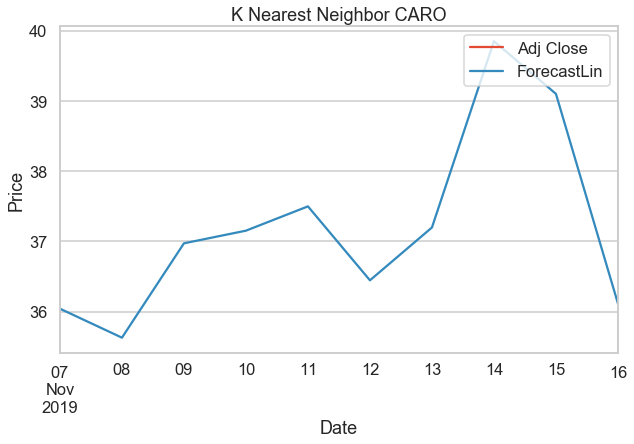

In [102]:
#Plot the Forecast
forecast_set = knn.predict(xLately)
data['ForecastLin'] = np.nan
print(forecast_set)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

print("Last Date: ", last_date)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    data.loc[next_date] = [np.nan for _ in range(len(data.columns)-1)]+[i]
    
data['Adj Close'].tail(10).plot()
data['ForecastLin'].tail(10).plot()
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('K Nearest Neighbor {}'.format(ticker))

[36.31346679 36.68052666 37.21926669 37.31117591 37.69521957 37.94038579
 38.14344657 38.55777541 38.71627092 38.31614909]


Text(0.5, 1.0, 'Linear Regression CARO')

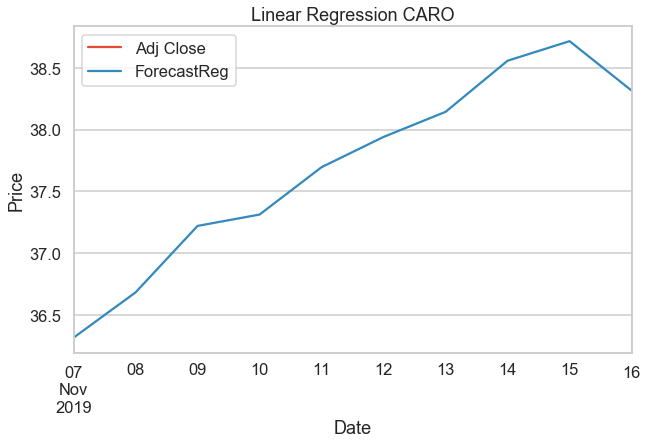

In [103]:
forecast_set = clfreg.predict(xLately)
data['ForecastReg'] = np.nan
print(forecast_set)
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    data.loc[next_date] = [np.nan for _ in range(len(data.columns)-1)]+[i]
    
data['Adj Close'].tail(10).plot()
data['ForecastReg'].tail(10).plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Linear Regression {}'.format(ticker))

[36.54789877 36.56139706 37.26367973 37.40846765 37.61081714 37.92096051
 38.06692121 38.46263453 38.62813077 38.08813271]


Text(0.5, 1.0, 'Poly Regression CARO')

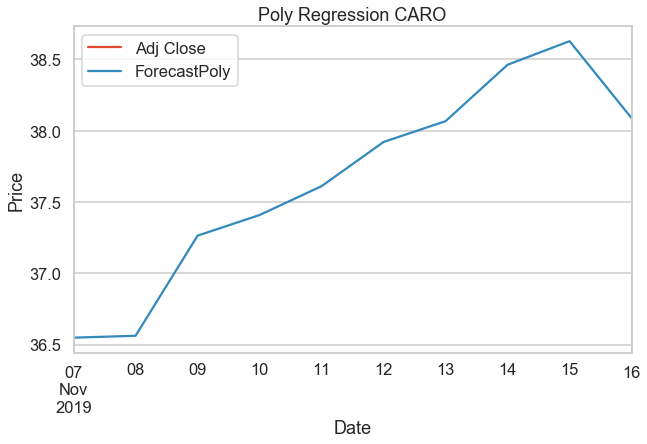

In [104]:
forecast_set = clfpoly2.predict(xLately)
data['ForecastPoly'] = np.nan
print(forecast_set)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    data.loc[next_date] = [np.nan for _ in range(len(data.columns)-1)]+[i]
    
data['Adj Close'].tail(10).plot()
data['ForecastPoly'].tail(10).plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Poly Regression {}'.format(ticker))

[36.67649612 36.07162933 35.72435875 36.27238235 36.60076103 38.58191299
 38.65021477 38.93227081 39.63150558 39.2545929 ]


Text(0.5, 1.0, 'Random Forest Regression CARO')

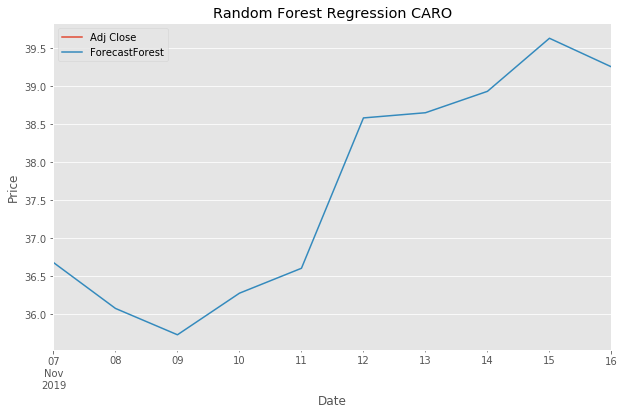

In [15]:
forecast_set = rfReg.predict(xLately)
data['ForecastForest'] = np.nan
print(forecast_set)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    data.loc[next_date] = [np.nan for _ in range(len(data.columns)-1)]+[i]
    
data['Adj Close'].tail(10).plot()
data['ForecastForest'].tail(10).plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Random Forest Regression {}'.format(ticker))

[34.33089201 34.33089201 34.33089201 34.33089201 35.65023792 36.10421608
 36.10421608 36.47816494 36.47816494 36.10421608]


Text(0.5, 1.0, 'Gradient Boost Regression CARO')

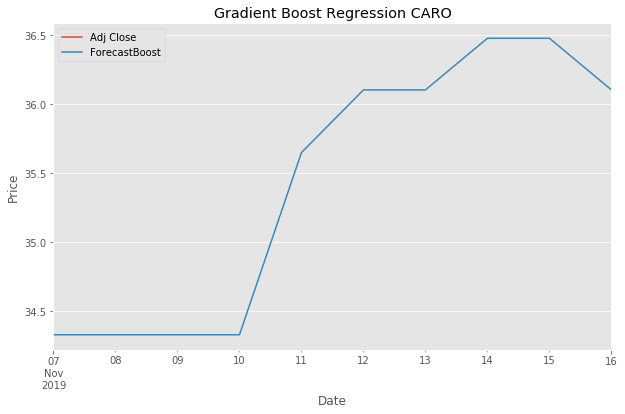

In [16]:
forecast_set = gboostReg.predict(xLately)
data['ForecastBoost'] = np.nan
print(forecast_set)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    data.loc[next_date] = [np.nan for i in range(len(data.columns)-1)]+[i]
    
data['Adj Close'].tail(10).plot()
data['ForecastBoost'].tail(10).plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gradient Boost Regression {}'.format(ticker))

In [17]:
data.tail(25)

,Adj Close,Volume,HL_PCT,PCT_change,label,ForecastLin,ForecastReg,ForecastPoly,ForecastForest,ForecastBoost
Date,,,,,,,,,,
2019-10-17,35.349998,29500.0,0.834518,-0.056546,37.950001,NaN,NaN,NaN,NaN,NaN
2019-10-18,35.669998,55900.0,1.934406,1.827004,38.150002,NaN,NaN,NaN,NaN,NaN
2019-10-21,35.770000,84900.0,1.537599,0.168024,38.529999,NaN,NaN,NaN,NaN,NaN
2019-10-22,36.130001,68700.0,1.605309,1.062940,38.689999,NaN,NaN,NaN,NaN,NaN
2019-10-23,36.439999,41300.0,2.305160,0.830103,38.220001,NaN,NaN,NaN,NaN,NaN
2019-10-24,36.160000,86300.0,1.078538,-0.850017,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-25,36.580002,52800.0,3.832696,-3.099333,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-28,37.310001,106800.0,2.573034,2.556350,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-29,37.200001,61000.0,0.913979,-0.534761,NaN,NaN,NaN,NaN,NaN,NaN
